# Fraud Detection using Unsupervised Learning
---
Taken from [Fraud Detection Handbook](https://fraud-detection-handbook.github.io/fraud-detection-handbook/Foreword.html) and [Robin Teuwen's Kaggle notebook](https://www.kaggle.com/code/robinteuwens/anomaly-detection-with-auto-encoders)

Data taken from [Lopez-Rojas's Paysim dataset](https://www.kaggle.com/datasets/ealaxi/paysim1)

## Pre-Requisites

### Importing the Libraries

In [1]:
# Turning off Tensorflow loggings
import logging, os
logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

In [2]:
# Importing some libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import joblib

# Importing TensorFlow and Keras Tuner
import tensorflow as tf
import keras_tuner as kt

# Importing the K-Means model
from sklearn.cluster import KMeans

# Importing the Gaussian Mixture model
from sklearn.mixture import GaussianMixture

# Importing datapreprocessing libraries
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Importing metrics from Scikit-Learn
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, f1_score, precision_score, recall_score, average_precision_score

In [3]:
# Plot styling
%matplotlib inline
sns.set_style("whitegrid")
plt.rcParams["font.family"] = "Times New Roman"

In [4]:
# Setting some save paths
graph_path = "Graphs"
autoencoder_path = "Models//Autoencoder"
kmeans_path = "Models//K-Means"
gmm_path = "Models//GMM"

# Creating paths if they don't exist
for path in [graph_path, autoencoder_path, kmeans_path, gmm_path]:
    if not os.path.exists(path):
        os.makedirs(path)

In [5]:
# Checking if GPU is available
if tf.test.is_gpu_available():
    print(tf.test.gpu_device_name())
else:
    print("No GPU available")

No GPU available


### Importing the Dataset

In [6]:
# Importing the data in
trx = pd.read_csv("Dataset//PS_20174392719_1491204439457_log.csv")

# Renaming the columns
trx.rename(columns={"oldbalanceOrg": "oldBalanceOrig", "newbalanceOrig": "newBalanceOrig", 
                    "oldbalanceDest": "oldBalanceDest", "newbalanceDest": "newBalanceDest"}, inplace=True)

# Previewing the data
trx.head()

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## Data Exploration

In [7]:
# Getting the dataset info
trx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldBalanceOrig  float64
 5   newBalanceOrig  float64
 6   nameDest        object 
 7   oldBalanceDest  float64
 8   newBalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [8]:
# Getting the shape of the data
trx.shape

(6362620, 11)

In [9]:
# Getting a description of the data
trx.describe()

,step,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [10]:
# Checking for missing values
(trx.isnull().sum() != 0).sum()

0

In [11]:
# Checking the distribution of the target variable
trx["isFraud"].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

In [12]:
# Ratio of non-fraud to fraud
trx["isFraud"].value_counts()[0]/ trx["isFraud"].value_counts()[1]

773.7010836478753

In [13]:
# Aggregating the data by the type of transaction
trx.groupby(["type", "isFraud"]).count()['step'].rename("count").to_frame()

count
type     isFraud         
CASH_IN  0        1399284
CASH_OUT 0        2233384
         1           4116
DEBIT    0          41432
PAYMENT  0        2151495
TRANSFER 0         528812
         1           4097

## Data Preprocessing

In [14]:
def clean_data(data):
    
    # Get the first letter of the nameOrig and nameDest columns
    data["nameOrig"] = data["nameOrig"].apply(lambda x: x[0])
    data["nameDest"] = data["nameDest"].apply(lambda x: x[0])

    # Concatenate the nameOrig and nameDest columns
    data["nameOrigDest"] = data["nameOrig"] + data["nameDest"]

    # Dropping the "nameOrig" and "nameDest" columns
    data.drop(["nameOrig", "nameDest"], axis=1, inplace=True)

    # Finding the change in balance for the origin and destination accounts
    data["origChange"] = data["newBalanceOrig"] - data["oldBalanceOrig"]
    data["destChange"] = data["newBalanceDest"] - data["oldBalanceDest"]

    # Modulo the step column by 24 to get the hour of the day
    data["hourOfDay"] = data["step"] % 24

    # Finding the day of the week
    data["day"] = data["step"] // 24 % 7

    # Mapping the day of the week to the actual day
    data["day"] = data["day"].map({0: "Monday", 1: "Tuesday", 2: "Wednesday", 3: "Thursday", 
                                   4: "Friday", 5: "Saturday", 6: "Sunday"})

    # Converting categorical types into one-hot encoding
    data = pd.concat([data, pd.get_dummies(data[["nameOrigDest", "type", "day"]], drop_first=True)], axis=1)

    # Dropping the redundant columns
    data.drop(["step", "newBalanceOrig", "newBalanceDest", "type", "isFlaggedFraud", "day", "nameOrigDest"], axis=1, inplace=True)

    return data

In [15]:
# Using the function to clean the data
data = clean_data(trx.copy())

# Fixing the column names
data.columns = data.columns.str.lower()
data.rename(columns={"isfraud": "is_fraud", "oldbalanceorig": "sender_balance_prev", "oldbalancedest": "receiver_balance_prev",
                     "origchange": "sender_balance_change", "destchange": "receiver_balance_change", 
                     "nameorigdest_cm": "cust_to_merchants", "hourofday": "hour_of_day"}, inplace=True)

In [16]:
# Separating the data into fraud and not fraud
fraud = data[data["is_fraud"] == 1]
not_fraud = data[data["is_fraud"] == 0]

In [17]:
# Selecting non-fraudulent transactions equal to the number of fraudulent transactions
X_test_not_fraud = not_fraud.sample(n=fraud.shape[0], random_state=42)

# Separating the remaining non-fraudulent transactions and the fraudulent transactions for the dev set
X_test = pd.concat([X_test_not_fraud, fraud], axis=0).sample(frac=1, random_state=42)
y_test = X_test["is_fraud"]
X_test = X_test.drop("is_fraud", axis=1)

# Getting only the non-fraudulent transactions for the training set and the dev set
X_train = not_fraud.drop(X_test_not_fraud.index)
y_train = X_train["is_fraud"]
X_train = X_train.drop("is_fraud", axis=1)

# Splitting the training data into train and train_dev sets
X_train, X_train_dev, y_train, y_train_dev = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Splitting the test data into test and dev sets
X_test, X_dev, y_test, y_dev = train_test_split(X_test, y_test, test_size=0.5, random_state=42, stratify=y_test)

In [18]:
# Scaling the data
scaler = StandardScaler()
scaler.fit(X_train)

# Transforming the data
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
X_train_dev = scaler.transform(X_train_dev)
X_dev = scaler.transform(X_dev)

## Modelling the Data

### Helper Functions

In [19]:
def plot_roc_curve(label, prediction, title=None, save=False):

    # Setting up a couple of plot settings
    title = title if title is not None else "the Model"

    # Calculating the FPR and TPR score at different thresholds
    fpr, tpr, thresholds = roc_curve(label, prediction)

    # Setting the figure size
    plt.figure(figsize=(10, 6))

    # Plotting the ROC curve
    plt.plot(fpr, tpr, label="ROC Curve")
    plt.plot([0, 1], [0, 1], label="Random Classifier")

    # Plot settings
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve for {}".format(title))
    plt.legend()
    sns.despine()

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "roc_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=True)

    # Displaying the plot
    plt.show()

In [20]:
def plot_pr_threshold(label, prediction, title=None, save=False):

    # Setting up a couple of plot settings
    title = title if title is not None else "the Model"

    # Calculating the precision and recall for different thresholds
    precision, recall, thresholds = precision_recall_curve(label, prediction)

    # Setting the figure size
    plt.figure(figsize=(10, 6))

    # Plotting the precision and recall for different thresholds
    plt.plot(thresholds, precision[1:], label="Precision")
    plt.plot(thresholds, recall[1:], label="Recall")

    # Plot settings
    plt.xlabel("Threshold")
    plt.ylabel("Precision/Recall")
    plt.title("Precision/Recall to Threshold Curve for {}".format(title))
    plt.legend()
    sns.despine()

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "prt_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=True)

    # Showing the plot
    plt.show()

In [21]:
def plot_precision_recall_curve(label, prediction, title=None, save=False):

    # Setting up a couple of plot settings
    title = title if title is not None else "the Model"

    # Calculating the precision and recall for different thresholds
    precision, recall, _ = precision_recall_curve(label, prediction)

    # Setting the figure size
    plt.figure(figsize=(10, 6))

    # Plotting the precision and recall for different thresholds
    plt.plot(recall, precision, label="Precision/Recall Curve")

    # Plot settings
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision/Recall Curve for {}".format(title))
    plt.legend()
    sns.despine()

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "prc_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=True)

    # Showing the plot
    plt.show()

In [22]:
def plot_confusion_matrix(label, prediction, title=None, save=False):

    # Setting up a couple of plot settings
    title = title if title is not None else "the Model"

    # Creating the confusion matrix
    cm = confusion_matrix(label, prediction)

    # Setting the figure size
    plt.figure(figsize=(10, 6))

    # Plotting the confusion matrix
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")

    # Plot settings
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix for {}".format(title))

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "cm_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=True)

    # Showing the plot
    plt.show()
    

In [23]:
def plot_dist(non_fraud, fraud, bins, metric, title=None, save=False):

    # Setting up a couple of plot settings
    metric = metric if metric is not None else "Metric"
    title = title if title is not None else "the Model"

    # Setting up the plot
    plt.figure(figsize=(10, 6))

    # Plotting the histogram of distances
    sns.histplot(non_fraud, bins=bins, alpha=0.5, label='Not Fraud')
    sns.histplot(fraud, bins=bins, alpha=0.5, label='Fraud')

    # Plot settings
    plt.xlabel(metric)
    plt.ylabel("Frequency")
    plt.title(f"Distribution of {metric} for {title}")
    plt.legend()
    sns.despine()

    # Saving the plot if specified
    if save and title is not None:
        path = os.path.join(graph_path, "dist_{}.png".format(str.lower(title)))
        plt.savefig(path, dpi=300, bbox_inches="tight", transparent=True)

    # Showing the plot
    plt.show()

In [24]:
def check_mean_std(raw_output, metric, verbose=True):
    
    # Calculating the mean and standard deviation of the raw output
    mean = np.mean(raw_output)
    std = np.std(raw_output)

    # Printing the mean and standard deviation if specified
    if verbose:
        print(f"Mean {metric}: {mean}")
        print(f"Standard Deviation {metric}: {std}")

    # Returning the mean and standard deviation
    return mean, std

In [25]:
def classifier_metrics(label, prediction, raw_prediction):
    
    # Accuracy score
    accuracy = accuracy_score(label, prediction)

    # F1 score
    f1 = f1_score(label, prediction)

    # Precision score
    precision = precision_score(label, prediction)

    # Recall score
    recall = recall_score(label, prediction)

    # AUC score
    auc = roc_auc_score(label, raw_prediction)

    # AUPRC score
    auprc = average_precision_score(label, raw_prediction)

    # Returning the scores
    return {"Accuracy": accuracy, "F1": f1, "Precision": precision, "Recall": recall, "AUC": auc, "AUPRC": auprc}

In [26]:
def load_or_retrain(filepath, model, X_train, model_args=None, retrain=False, tensorflow=False, save_model=True, log_path=None):
        
    # Checking if the model has already been trained
    if os.path.exists(filepath): print("File already exists")

    # Checking if the model is a tensorflow model
    if tensorflow:

        if not retrain:

            # Printing the status
            print("Loading the model...")

            # Loading the model
            model.load_weights(filepath)
        else:
            # Printing the status
            print("Training the model...")

            # Training the model
            history = model.fit(X_train, X_train, 
                                **model_args)

            # Saving the model if specified
            if save_model:
                # Saving the model's weight (weird how subclassing somehow doesn't save the model properly)
                model.save_weights(filepath, save_format="h5")

                # Printing the status
                print(f"Model trained and saved to {filepath}")

            # Saving the training history if specified
            if log_path is not None:
                joblib.dump(history.history, log_path)

                print(f"Training history saved to {log_path}")

    else:
        # Checking if the model has already been trained
        if not retrain:

            # Printing the status
            print("Loading the model...")

            # Loading the model
            model = joblib.load(filepath)

        # Training the model
        else:
            # Printing the status
            print("Training the model...")
            
            # Training the model
            model.fit(X_train)

            # Saving the model if specified
            if save_model:
                joblib.dump(model, filepath)

                # Printing the status
                print(f"Model trained and saved to {filepath}")
    
    # Returning the model
    return model

In [27]:
def tune_model_to(label, raw_prediction, thresholds=np.arange(0, 1), metric=f1_score):
    
        # Setting up the best score and best threshold
        best_score = 0
        best_threshold = 0
    
        # Looping through the thresholds
        for threshold in thresholds:
    
            # Converting the raw prediction to a binary prediction
            prediction = np.where(raw_prediction > threshold, 1, 0)
    
            # Calculating the score
            score = metric(label, prediction)
    
            # Checking if the score is better than the best score
            if score > best_score:
                best_score = score
                best_threshold = threshold
    
        # Returning the best threshold and best score
        return best_threshold, best_score

### K-Means Clustering

#### Training the Model

In [28]:
# Creating the K-Means model
kmeans = KMeans(n_clusters=1, random_state=42, n_init=10, max_iter=1000)

# Fitting the model
kmeans = load_or_retrain(filepath=os.path.join(kmeans_path, "kmeans.pkl"), model=kmeans, 
                         X_train=X_train, retrain=False, save_model=True)

File already exists
Loading the model...


#### Tuning the Model on the Dev Set

In [29]:
# Raw distance scores for the test set
km_distance_dev = kmeans.transform(X_dev).reshape(-1)

km_threshold, _ = tune_model_to(label=y_dev, raw_prediction=km_distance_dev, thresholds=np.arange(0, 10, step=.01), metric=f1_score)

# Getting the predictions
km_pred_dev = (km_distance_dev  > km_threshold).astype(int)

In [30]:
# Evaluating the model
km_dev_eval = classifier_metrics(y_dev, km_pred_dev, km_distance_dev)

# Displaying the evaluation metrics
km_dev_eval

{'Accuracy': 0.8336783148666748,
 'F1': 0.8341830541393542,
 'Precision': 0.8315585672797676,
 'Recall': 0.8368241597661958,
 'AUC': 0.8960817493946336,
 'AUPRC': 0.9077990903313518}

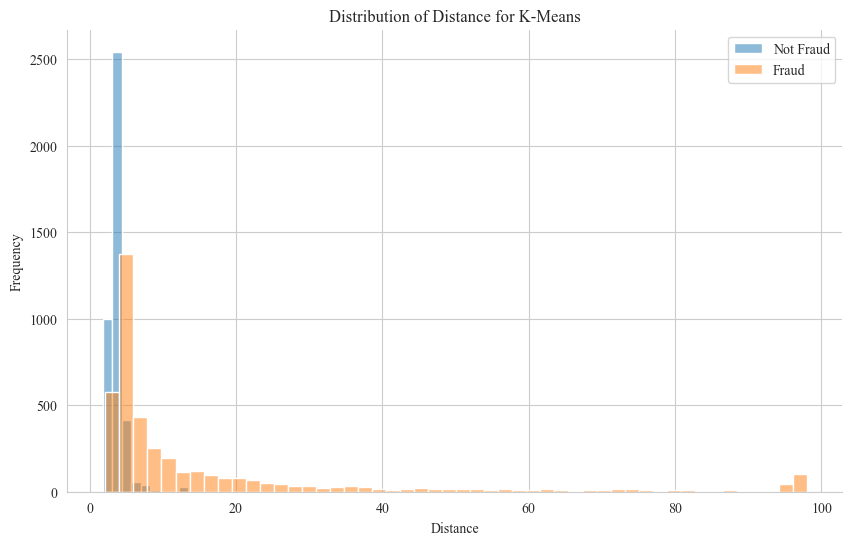

In [31]:
# Distribution of distances
plot_dist(km_distance_dev[y_dev == 0], km_distance_dev[y_dev == 1], 50, "Distance", "K-Means")

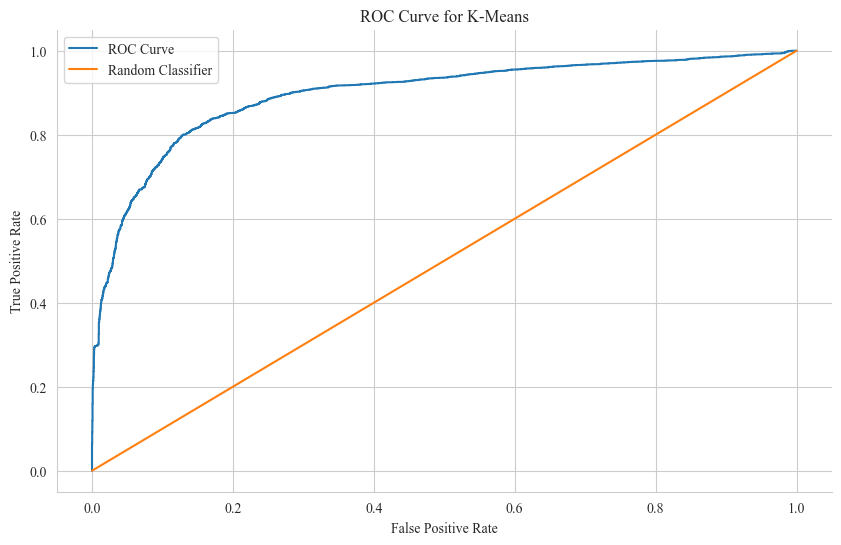

In [32]:
# Plotting the ROC curve
plot_roc_curve(y_dev, km_distance_dev , title="K-Means")

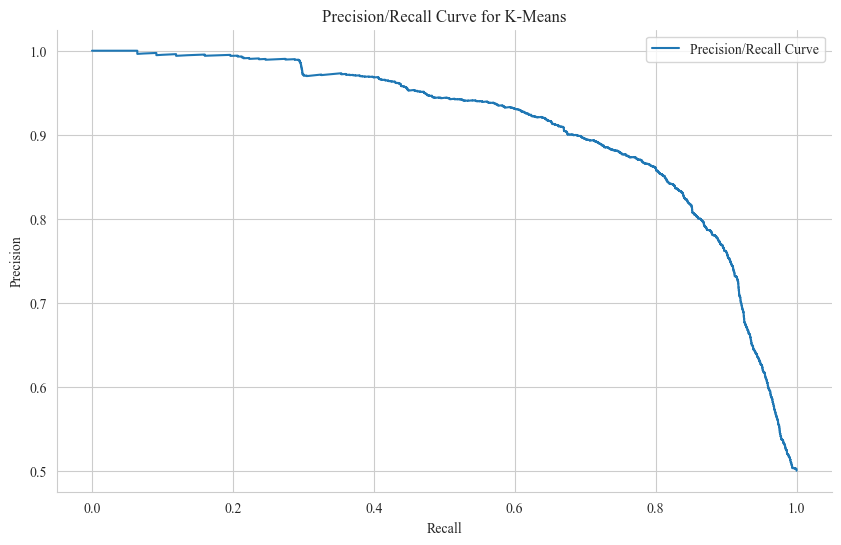

In [33]:
# Plotting the precision-recall curve
plot_precision_recall_curve(y_dev, km_distance_dev, title="K-Means")

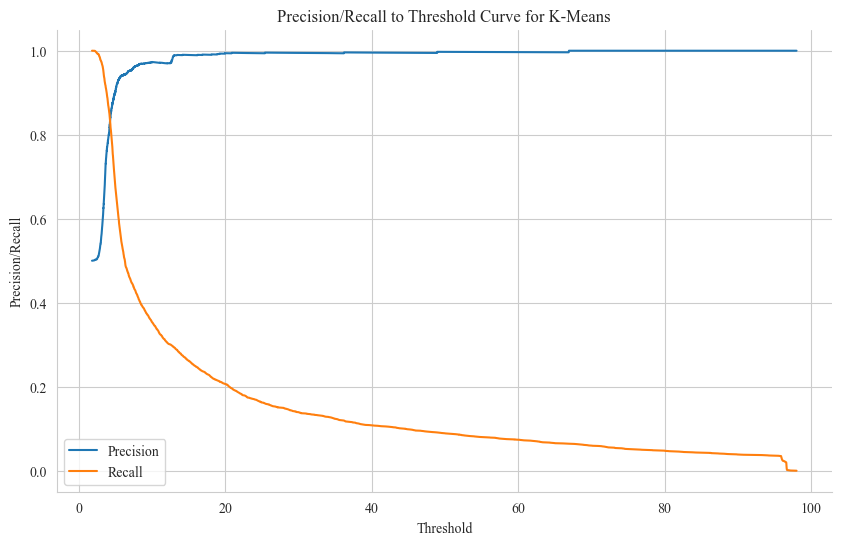

In [34]:
# Plotting the precision/recall to threshold curve
plot_pr_threshold(y_dev, km_distance_dev , title="K-Means")

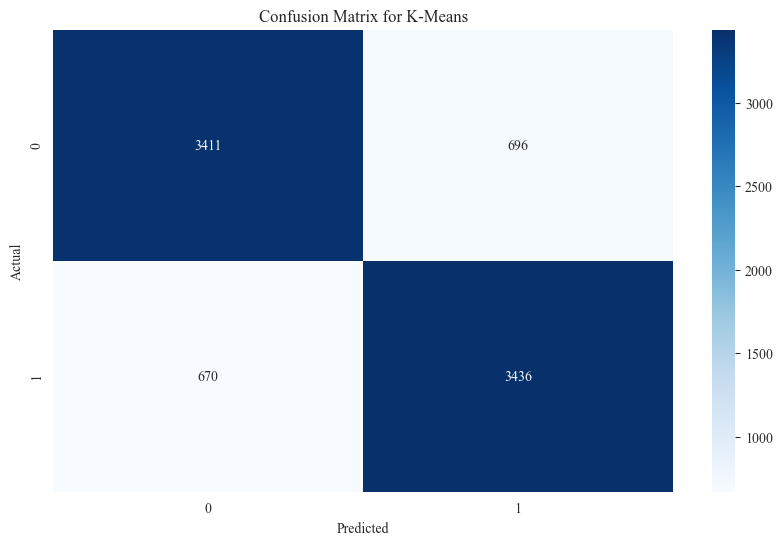

In [35]:
# Plotting the confusion matrix
plot_confusion_matrix(y_dev, km_pred_dev , title="K-Means")

### Gaussian Mixture

#### Training the Model

In [36]:
# Creating the Gaussian Mixture model
gmm = GaussianMixture(n_components=1, random_state=42, n_init=10, max_iter=1000)

# Fitting the model
gmm = load_or_retrain(filepath=os.path.join(gmm_path, "gmm.pkl"), model=gmm, 
                      X_train=X_train, retrain=False, save_model=True)

File already exists
Loading the model...


#### Tuning the Model on the Dev Set

In [37]:
# Raw density scores for the test set
gmm_density_dev = np.abs(gmm.score_samples(X_dev))

# Tuning the threshold
gmm_threshold, _ = tune_model_to(label=y_dev, raw_prediction=gmm_density_dev, thresholds=np.arange(0, 70, step=.1), metric=f1_score)

# Getting the predictions
gmm_pred_dev = (gmm_density_dev > gmm_threshold).astype(int)

In [38]:
# Evaluating the model
gmm_dev_eval = classifier_metrics(y_dev, gmm_pred_dev, gmm_density_dev)

# Displaying the evaluation metrics
gmm_dev_eval

{'Accuracy': 0.8525508340435894,
 'F1': 0.8487951055063053,
 'Precision': 0.8708685626441199,
 'Recall': 0.8278129566488066,
 'AUC': 0.912121333956223,
 'AUPRC': 0.9239239441114478}

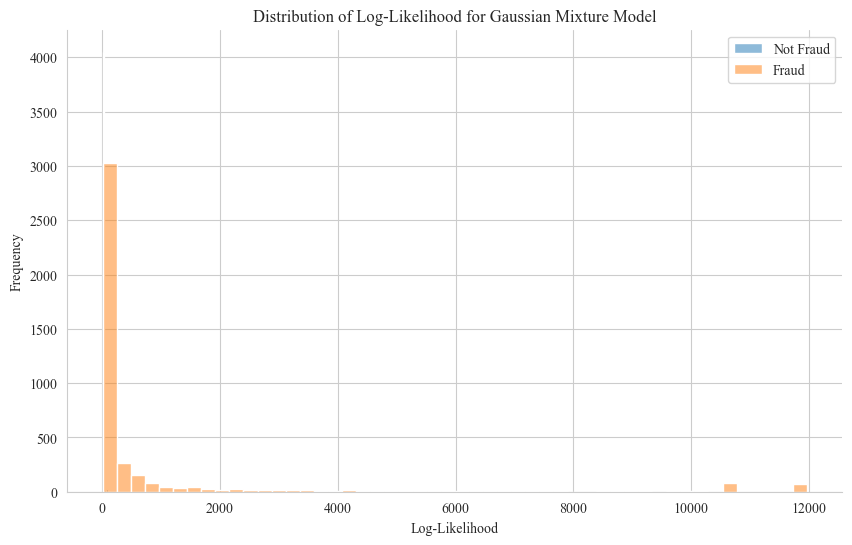

In [39]:
# Distribution of Log-Likelihood
plot_dist(gmm_density_dev[y_dev == 0], gmm_density_dev[y_dev == 1], 50, "Log-Likelihood", "Gaussian Mixture Model")

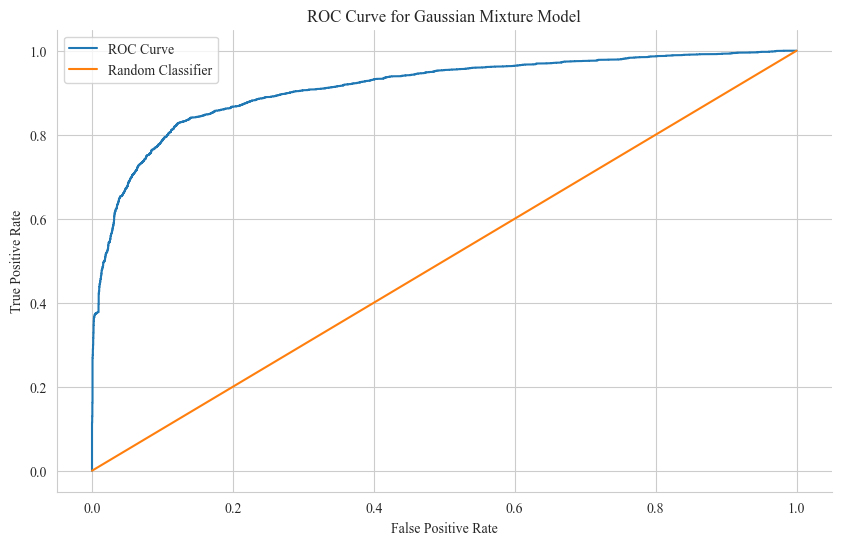

In [40]:
# Plotting the ROC curve
plot_roc_curve(y_dev, gmm_density_dev, title="Gaussian Mixture Model")

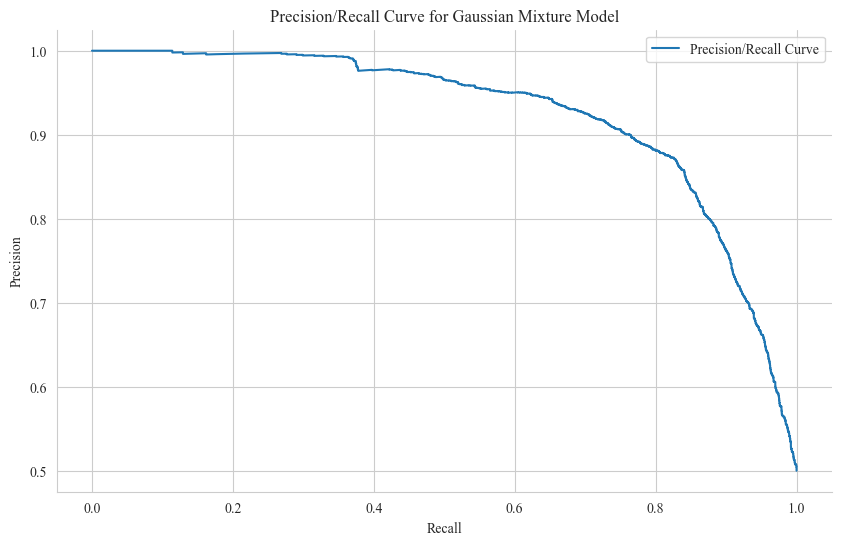

In [41]:
# Plotting the precision-recall curve
plot_precision_recall_curve(y_dev, gmm_density_dev, title="Gaussian Mixture Model")

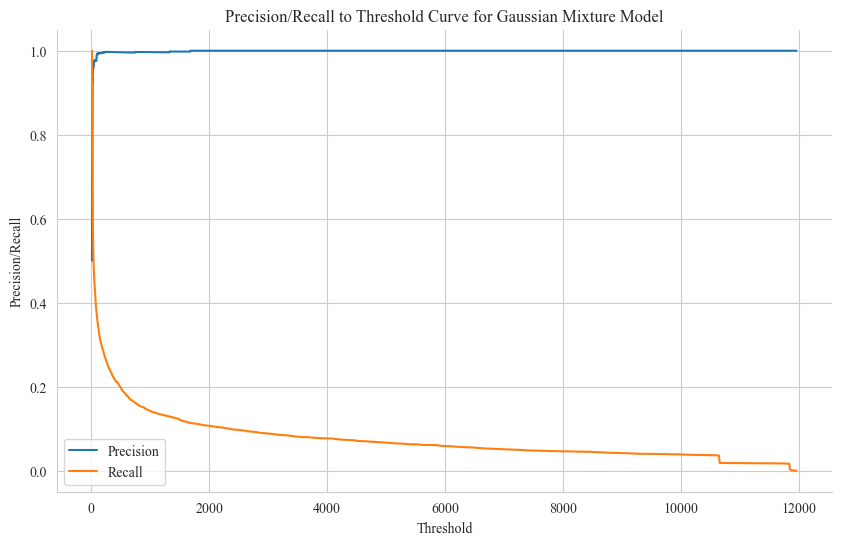

In [42]:
# Plotting the precision/recall to threshold curve
plot_pr_threshold(y_dev, gmm_density_dev, title="Gaussian Mixture Model")

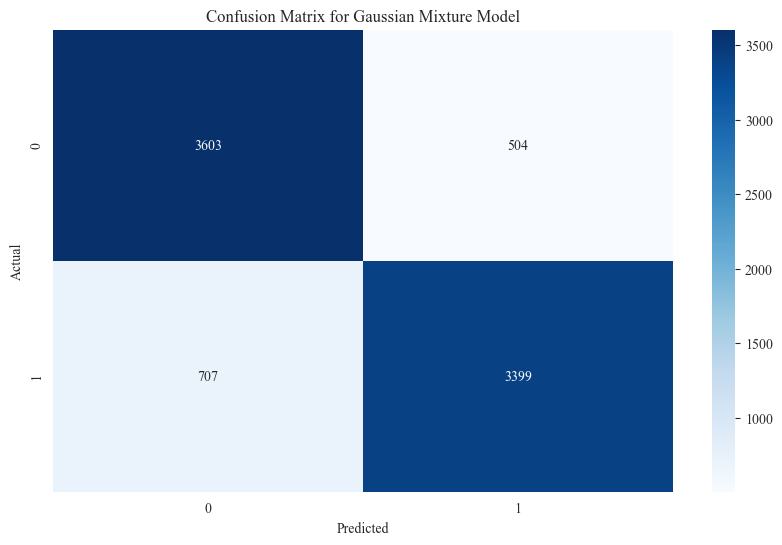

In [43]:
# Plotting the confusion matrix
plot_confusion_matrix(y_dev, gmm_pred_dev, title="Gaussian Mixture Model")

### Autoencoder

#### Building the AutoEncoder

In [44]:
# Creating the Encoder model
class Encoder(tf.keras.Model):
    def __init__(self, input_size, latent_size=2, hidden_layers=2,
                 activation="elu", dropout=0.2):
        
        # Initializing the model using the super() function
        super(Encoder, self).__init__(name="encoder")

        # Calculating the number of units in each hidden layer
        self.hidden_units = (latent_size ** np.arange(2, hidden_layers + 1))[::-1].tolist() + [latent_size]
        
        # Creating the hidden layers
        self.layer_stack = tf.keras.Sequential(name="encoder_stack")
        for units in self.hidden_units:
            self.layer_stack.add(tf.keras.layers.Dense(units, activation=activation))

        # Creating the dropout layer to give noise to the input (only during training)
        self.dropout = tf.keras.layers.Dropout(dropout, name="input_noise")
        
    def call(self, x):
        # Adding noise to the input (only during training)
        x = self.dropout(x)

        # Passing the input through the hidden layers
        x = self.layer_stack(x)
        return x

In [45]:
# Creating the Decoder model
class Decoder(tf.keras.Model):
    def __init__(self, input_size, output_size, hidden_layers=2,
                 encoder_units=None, activation="elu"):
        
        # Initializing the model using the super() function
        super(Decoder, self).__init__(name="decoder")

        # Creating the hidden layers
        self.layer_stack = tf.keras.Sequential(name="decoder_stack")

        # Calculating the number of units in each hidden layer if not specified
        if encoder_units is None: 

            self.hidden_units = (input_size ** np.arange(2, hidden_layers + 1)) + [output_size]
        
        # Using the encoder units if specified
        else:
            self.hidden_units = encoder_units[::-1][1:] + [output_size]

        # Creating the hidden layers
        self.layer_stack = tf.keras.Sequential(name="decoder_stack")

        # Creating the hidden layers
        for units in list(self.hidden_units):
            self.layer_stack.add(tf.keras.layers.Dense(units, activation=activation))

    def call(self, x):
        # Passing the input through the hidden layers
        x = self.layer_stack(x)
        return x

In [46]:
# Creating the Autoencoder model
class Autoencoder(tf.keras.Model):
    def __init__(self, input_size, latent_size, hidden_layers=2, activation='elu', dropout=0.2):

        # Initializing the model using the super() function
        super(Autoencoder, self).__init__(name="autoencoder")

        # Creating the encoder
        self.encoder = Encoder(input_size=input_size, latent_size=latent_size, 
                               hidden_layers=hidden_layers, activation=activation, dropout=dropout)
        
        # Creating the decoder
        self.decoder = Decoder(input_size=latent_size, output_size=input_size, 
                               hidden_layers=hidden_layers, encoder_units=self.encoder.hidden_units, activation=activation)

    def call(self, x):
        # Passing the input through the encoder and decoder
        x = self.encoder(x)

        # Passing the output of the encoder through the decoder
        x = self.decoder(x)
        return x

#### Tuning the Autoencoder

In [47]:
class AutoencoderTune(kt.HyperModel):
    def __init__(self, name=None, tunable=True, input_size=X_train.shape[1]):
        super().__init__(name, tunable)

        # Setting the input size (it's fixed for this dataset)
        self.input_size = input_size

    def param_choice(self, hp):
        # Defining the hyperparameters to tune
        latent_size = hp.Choice("latent_size", values=[2, 3, 4])
        hidden_layers = hp.Int("hidden_layers", min_value=2, max_value=5, step=1)
        learning_rate = hp.Float("learning_rate", min_value=1e-5, max_value=1e-2, sampling="log")
        activation = hp.Choice("activation", values=["elu", "relu", "tanh", "leaky_relu"])
        dropout_rate = hp.Float("dropout_rate", min_value=0.0, max_value=0.5, step=0.05)
        return latent_size, learning_rate, activation, hidden_layers, dropout_rate
    
    def build(self, hp):
        # Getting the hyperparameters
        latent_size, learning_rate, activation, hidden_layers, dropout_rate = self.param_choice(hp)

        # TensorFlow random seed
        tf.keras.utils.set_random_seed(42)

        # Creating the model
        model = Autoencoder(input_size=self.input_size, latent_size=latent_size, hidden_layers=hidden_layers,
                            activation=activation, dropout=dropout_rate)
        
        # Compiling the model
        model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")

        return model
    
    def fit(self, hp, model, *args, **kwargs):
        # Fitting the model
        return model.fit(*args, **kwargs)

In [48]:
# Training hyperparams
input_size = X_train.shape[1]
batch_size = 2 ** 15
epochs = 500
early_stopping_patience = 50

# Setting up the tuner
tuner = kt.Hyperband(AutoencoderTune(input_size=input_size), objective=kt.Objective('val_loss', 'min'), 
                     max_epochs=epochs, factor=8, directory=os.path.join(autoencoder_path, 'hyperband'), 
                     project_name="autoencoder", seed=42, overwrite=False)

# Setting up the early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping_patience,
                                                  restore_best_weights=True)   

In [49]:
# # Fitting the tuner
# tuner.search(X_train, X_train, epochs=epochs, batch_size=batch_size, 
#              validation_data=(X_train_dev, X_train_dev),callbacks=[early_stopping])

# # Saving the optimal hyperparameters
# joblib.dump(tuner.get_best_hyperparameters()[0].values, os.path.join(autoencoder_path, "best_hps.pkl"))

In [50]:
# Getting the optimal hyperparameters
best_hps_ae = joblib.load(os.path.join(autoencoder_path, "best_hps.pkl"))
best_hps_ae

{'latent_size': 4,
 'hidden_layers': 5,
 'learning_rate': 0.0006461809763075458,
 'activation': 'leaky_relu',
 'dropout_rate': 0.0,
 'tuner/epochs': 500,
 'tuner/initial_epoch': 63,
 'tuner/bracket': 1,
 'tuner/round': 1,
 'tuner/trial_id': '0108'}

#### Training the Autoencoder

In [51]:
# Clearing the session
tf.keras.backend.clear_session()

# TensorFlow random seed
tf.keras.utils.set_random_seed(42)

# Creating the model
ae = Autoencoder(input_size=input_size, latent_size=best_hps_ae["latent_size"],
                    hidden_layers=best_hps_ae["hidden_layers"], activation=best_hps_ae["activation"],
                    dropout=best_hps_ae["dropout_rate"])

# Building the model
ae.build(input_shape=(None, input_size))

# Compiling the model
ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=best_hps_ae["learning_rate"]), loss="mse")

# Previewing the model architecture
ae.summary()

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder (Encoder)           multiple                  298388    
                                                                 
 decoder (Decoder)           multiple                  298401    
                                                                 
Total params: 596,789
Trainable params: 596,789
Non-trainable params: 0
_________________________________________________________________


In [52]:
# Training hyperparams
input_size = X_train.shape[1]
batch_size = 2 ** 15
epochs = 1500
early_stopping_patience = 50

# Early stopping callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor="loss", patience=early_stopping_patience, mode="min", 
                                                  restore_best_weights=True, verbose=0)

# Model checkpoint callback
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(autoencoder_path, 'current_best_model.h5'),   
                                                      monitor="val_loss", save_best_only=True, mode="min", verbose=0,
                                                      save_weights_only=True, save_format="h5")

In [53]:
# Defining the model_args
model_args = {"validation_data": (X_train_dev, X_train_dev), "epochs": epochs, 
              "batch_size": batch_size, "callbacks": [early_stopping, model_checkpoint]}

# Fitting the model
ae = load_or_retrain(filepath=os.path.join(autoencoder_path, "fraud_autoencoder.h5"), model=ae, 
                     X_train=X_train, model_args=model_args, retrain=False, tensorflow=True, 
                     save_model=True, log_path=os.path.join(autoencoder_path, "losses.pkl"))

File already exists
Loading the model...


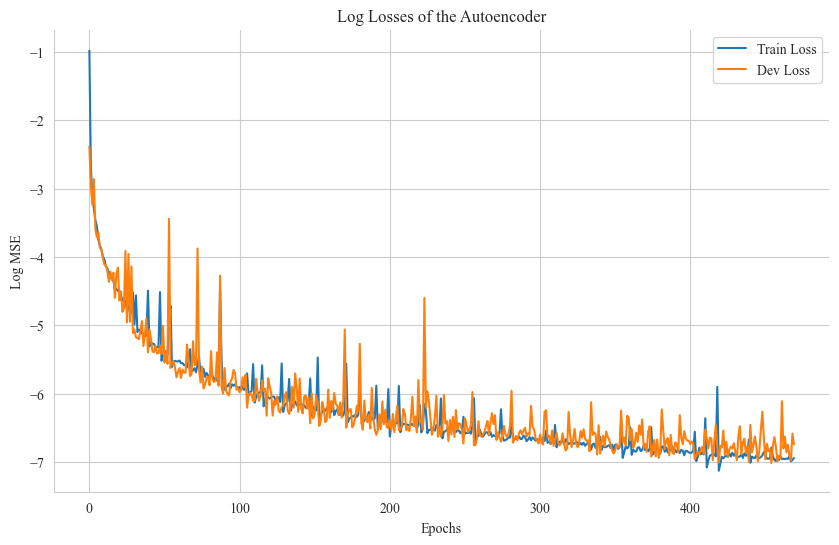

In [54]:
# Reloading the losses
losses = joblib.load(os.path.join(autoencoder_path, "losses.pkl"))

# Setting the figure size
plt.figure(figsize=(10, 6))

# Plotting the training and dev losses
plt.plot(np.log(losses['loss']), label="Train Loss")
plt.plot(np.log(losses['val_loss']), label="Dev Loss")

# Plot settings
plt.xlabel("Epochs")
plt.ylabel("Log MSE")
plt.title("Log Losses of the Autoencoder")
plt.legend()
sns.despine()

# Showing the plot
plt.show()

#### Tuning the Model on the Dev Set

In [55]:
# Reconstruction loss for each sample
sample_recon_loss = lambda label, pred: tf.reduce_mean(tf.square(tf.subtract(label, pred)), axis=1).numpy()

In [56]:
# Raw reconstruction loss for each sample
ae_recon_dev = sample_recon_loss(X_dev, ae.predict(X_dev, verbose=0))

# Tuning the threshold
ae_threshold, _ = tune_model_to(label=y_dev, raw_prediction=ae_recon_dev, thresholds=np.arange(0, 0.05, 0.0001), metric=f1_score)

# Getting the predictions
ae_pred_dev = (ae_recon_dev > ae_threshold).astype(int)

In [57]:
# Evaluating the model
ae_dev_eval = classifier_metrics(y_dev, ae_pred_dev, ae_recon_dev)

# Displaying the results
ae_dev_eval

{'Accuracy': 0.8562035796907342,
 'F1': 0.8571428571428572,
 'Precision': 0.8514780100937275,
 'Recall': 0.8628835849975646,
 'AUC': 0.9298864365082556,
 'AUPRC': 0.9370032885872764}

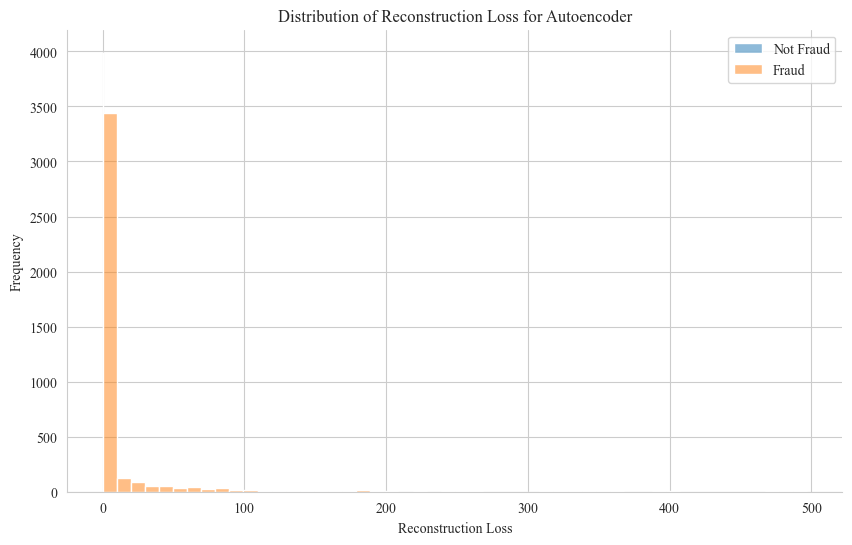

In [58]:
# Distribution of the Reconstruction Loss
plot_dist(ae_recon_dev[y_dev == 0], ae_recon_dev[y_dev == 1], 50, 
          "Reconstruction Loss", "Autoencoder")

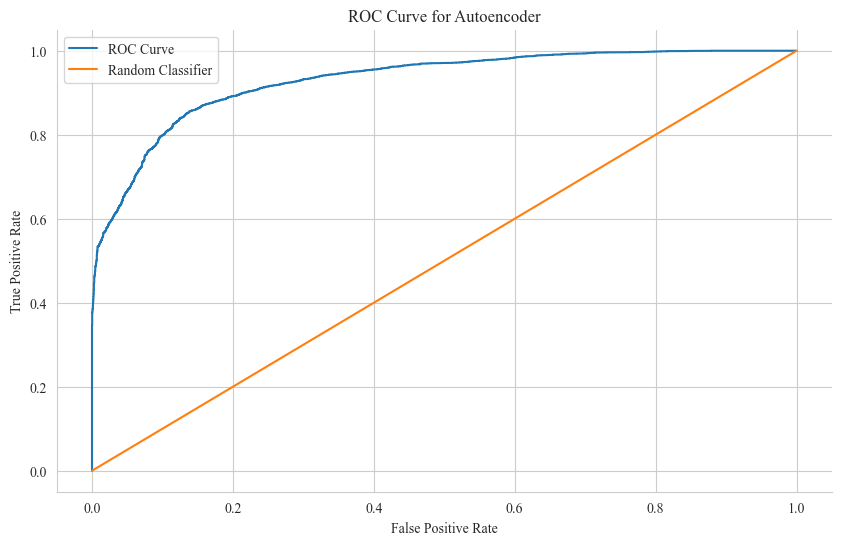

In [59]:
# Plotting the ROC curve
plot_roc_curve(y_dev, ae_recon_dev, "Autoencoder")

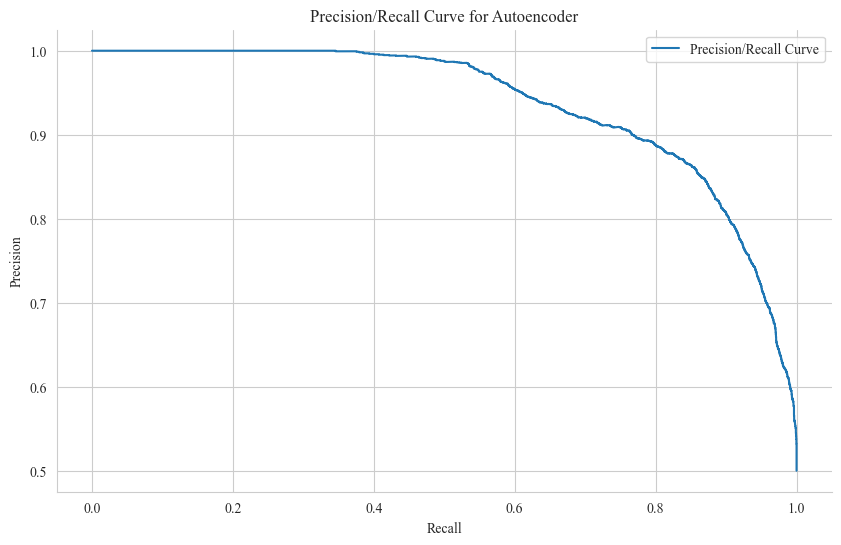

In [60]:
# Plotting the precision-recall curve
plot_precision_recall_curve(y_dev, ae_recon_dev, "Autoencoder")

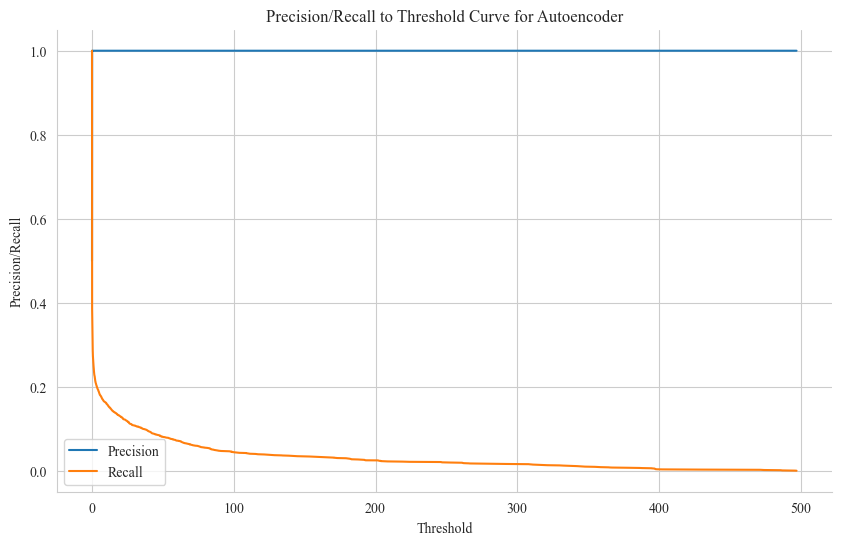

In [61]:
# Plotting the precision/recall to threshold curve
plot_pr_threshold(y_dev, ae_recon_dev, "Autoencoder")

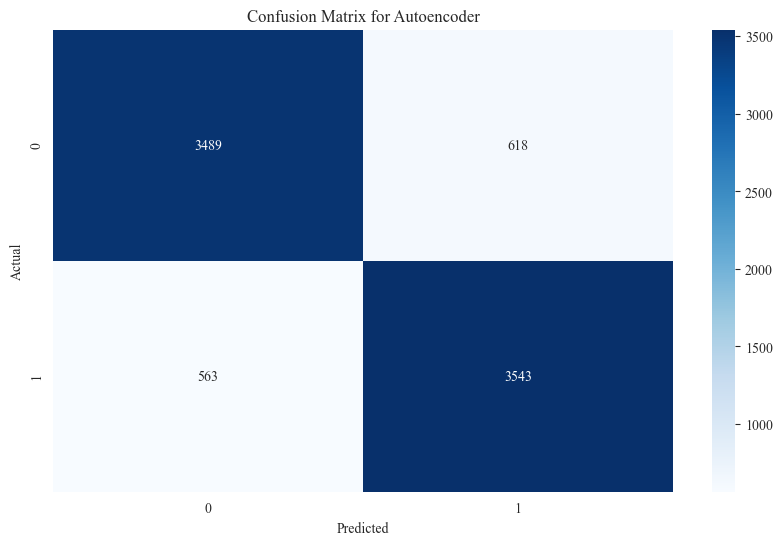

In [62]:
# Plotting the confusion matrix
plot_confusion_matrix(y_dev, ae_pred_dev, "Autoencoder")

## Comparison of Models

In [63]:
# Creating a dataframe with the metrics for the dev set
dev_metrics = pd.DataFrame([km_dev_eval, gmm_dev_eval, ae_dev_eval], index=["K-Means", "Gausian Mixture", "Autoencoder"])

# Displaying the metrics
dev_metrics

,Accuracy,F1,Precision,Recall,AUC,AUPRC
K-Means,0.833678,0.834183,0.831559,0.836824,0.896082,0.907799
Gausian Mixture,0.852551,0.848795,0.870869,0.827813,0.912121,0.923924
Autoencoder,0.856204,0.857143,0.851478,0.862884,0.929886,0.937003


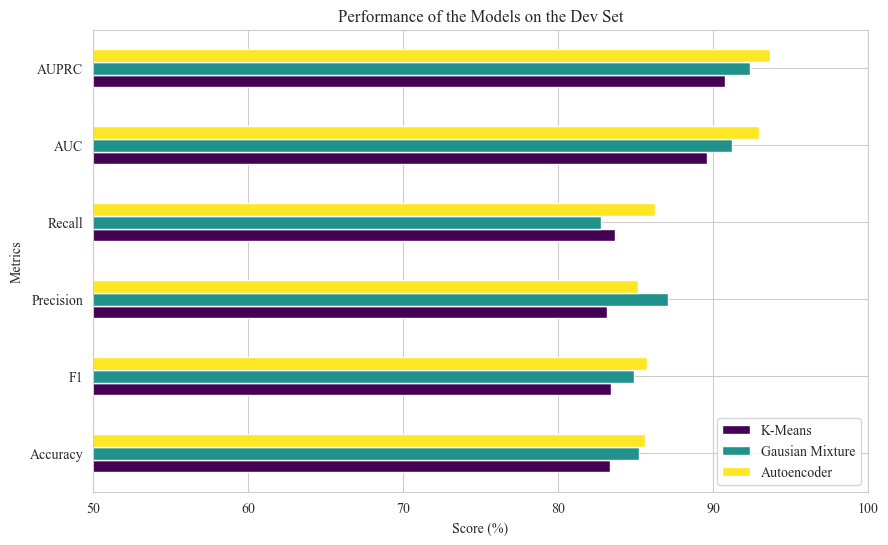

In [73]:
# Plotting the performance of the models aggregated by metric
(dev_metrics.T * 100).plot(kind="barh", rot=0, figsize=(10, 6), cmap="viridis")

# Plot settings
plt.ylabel("Metrics")
plt.xlabel("Score (%)")
plt.title("Performance of the Models on the Dev Set")
plt.xlim(50, 100)

# Showing the plot
plt.show()

In [65]:
# Evaluating the best model on the test set
ae_recon_test = sample_recon_loss(X_test, ae.predict(X_test, verbose=0))

# Getting the predictions
ae_pred_test = (ae_recon_test > ae_threshold).astype(int)

In [66]:
# Evaluating the model
ae_test_eval = classifier_metrics(y_test, ae_pred_test, ae_recon_test)

# Displaying the results
ae_test_eval

{'Accuracy': 0.8490198465846828,
 'F1': 0.8491851131111653,
 'Precision': 0.848359659781288,
 'Recall': 0.8500121743364987,
 'AUC': 0.92701879615559,
 'AUPRC': 0.9335552994308991}